In [1]:

# !pip install torchviz

# Autograd

We want to learn A and B such that `t = Ax + B`,(solution for our data is A = 2, B = 3)

In [2]:
import torch
x = torch.tensor([1., 2.])
t = torch.tensor([5., 7.])
# using wrong input for training
A = torch.tensor([3.], requires_grad=True)
B = torch.tensor([5.], requires_grad=True)

Define model as following:

In [3]:
def model(x):
    scaled = A * x
    return scaled + B

We define a loss function to measure how far the output of our model is from the expected (target) values. This is a squared-error loss.

In [4]:
def loss_fn(y, t):
    diff = y - t;
    sqdiff = diff ** 2
    return sqdiff.sum()

Here is our "optimizer step". After we've computed gradients for A and B, we will update A and B via stochastic gradient descent.

In [5]:
def sgd_step(lr = 0.1):
    global A
    global B
    with torch.no_grad():
        A -= A.grad * lr
        A.grad.zero_()
        B -= B.grad * lr
        B.grad.zero_()

train the model:

In [6]:
for i in range(1000):
    y = model(x)
    loss = loss_fn(y, t)
    loss.backward()
    sgd_step()
    if i % 100 == 0:
        print("loss: {}, A: {}, B: {}".format(loss, A.item(), B.item()))

loss: 25.0, A: 0.7999999523162842, B: 3.5999999046325684
loss: 0.0005399102228693664, A: 1.9689515829086304, B: 3.0502371788024902
loss: 1.445937641619821e-06, A: 1.9983934164047241, B: 3.0025997161865234
loss: 3.852846930385567e-09, A: 1.9999167919158936, B: 3.0001344680786133
loss: 1.0231815394945443e-11, A: 1.9999959468841553, B: 3.0000064373016357
loss: 1.1368683772161603e-12, A: 1.9999983310699463, B: 3.000002861022949
loss: 1.1368683772161603e-12, A: 1.9999983310699463, B: 3.000002861022949
loss: 1.1368683772161603e-12, A: 1.9999983310699463, B: 3.000002861022949
loss: 1.1368683772161603e-12, A: 1.9999983310699463, B: 3.000002861022949
loss: 1.1368683772161603e-12, A: 1.9999983310699463, B: 3.000002861022949


Put forward togather to manual calculate grad:

In [7]:
x = torch.tensor([1., 2.])
t = torch.tensor([5., 7.])
# using wrong input for training
A = torch.tensor([3.], requires_grad=True)
B = torch.tensor([5.], requires_grad=True)

# Forward
scaled = A * x
y = scaled + B
diff = y - t
sqdiff = diff ** 2
loss = sqdiff.sum()



The goal for gradient descent is to compute the gradient of the loss with respect to the input parameters. In the above example, since we are learning A and B, we want to compute $\frac{\partial loss}{\partial A}, \frac{\partial loss}{\partial B}$.


We can compute these via the chain rule.

$ \frac{\partial loss}{\partial A} = \sum_i \frac{\partial loss}{\partial sqdiff_i} * \frac{\partial sqdiff_i}{\partial A}$ (applied chain rule once)

$= \sum_i \frac{\partial loss}{\partial sqdiff_i} * \frac{\partial sqdiff_i}{\partial diff_i} * \frac{\partial diff_i}{\partial A}$

$= \sum_i \frac{\partial loss}{\partial sqdiff_i} * \frac{\partial sqdiff_i}{\partial diff_i} * \frac{\partial diff_i}{\partial y_i} * \frac{\partial y_i}{\partial scaled_i} * \frac{\partial scaled_i}{\partial A}$ (keep applying chain rule)

Things we know:
$$ \frac{\partial loss}{\partial sqdiff_i} = 1$$

$$ \frac{\partial sqdiff_i}{\partial diff_i} = 2 * diff_i$$

$$ \frac{\partial diff_i}{\partial y_i} = 1 $$

$$ \frac{\partial y_i}{\partial scaled_i} = 1 $$

$$ \frac{\partial scaled_i}{\partial A} = x_i $$

Plugging everything back in, we get:

$$ \frac{\partial loss}{\partial A} = \sum_i 2 * diff_i * x_i$$

Let's verify our math really quickly:

In [8]:
# backward
grad_A = (2 * diff * x).sum()
grad_B = (2 * diff).sum()
expected = torch.autograd.grad(loss, [A,B], retain_graph=True)
assert torch.allclose(grad_A, expected[0])
assert torch.allclose(grad_B, expected[1])

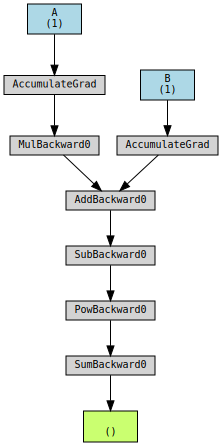

In [11]:
import torchviz
torchviz.make_dot(loss, params={'A': A, 'B': B, 'x': x, 'diff': diff})



What is this AccumulateGrad Node?

Every leaf Tensor that requires gradient gets an AccumulateGrad Node associated with it. That Node is used to link back to the Tensor and know on which Tensor the gradients should be accumulated. Note that the AccumulateGrad Nodes are the only Nodes that do not have parents pointing to them.


`loss.backward()` invokes a series of operations on this graph. In Pseudocode:

```
grad_sqdiff = SumBackward(sqdiff.shape).apply(1.)
grad_diff = PowBackward(base: diff, power: 2).apply(grad_sqdiff)
grad_y = SubBackward().apply(grad_diff)
grad_scaled, grad_B = AddBackward().apply(grad_y)
grad_A = MulBackward(other: X).apply(grad_scaled)
```

`SumBackward(input_shape).apply(grad)` is `grad.expand(input_shape)`.

`PowBackward(base, power).apply(grad)` is `grad * power * base ** (power - 1)`. 

And so on...

## What about these saved Tensors that might be needed for backward?

Autograd will automatically save all the required data to be able to compute the backward pass.

You can actually see these saved properties here:

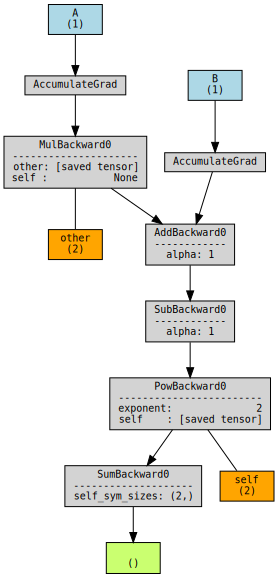

In [12]:
torchviz.make_dot(loss, params={'A': A, 'B': B, 'x': x, 'diff': diff}, show_attrs=True, show_saved=True)